<a href="https://colab.research.google.com/github/anqi-guo/duplicated_complaints_identification/blob/main/4_sbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

path = '/content/drive/My Drive/work/重复线索识别/data/processed_data/labeled_data'

df = pd.read_excel(f'{path}/final_data.xlsx')

,label,sentence1,sentence2
0,0.0,朝阳路与西安南路叉口向东关城小区拖运渣土污染末清理，冲洗,朝阳路与西安路交叉口东200m关城花苑大面积黄土裸露未覆盖
1,0.0,朝阳路与西安南路叉口向东关城小区拖运渣土污染末清理，冲洗,西安南路与朝阳路交叉口西南100m关城花苑大面积黄土裸露未覆盖。
2,0.0,朝阳路与西安南路叉口向东关城小区拖运渣土污染末清理，冲洗,朝阳路与西安路交叉口东300米 关城花苑大面积黄土裸露未覆盖
3,1.0,朝阳路与西安路交叉口东200m关城花苑大面积黄土裸露未覆盖,西安南路与朝阳路交叉口西南100m关城花苑大面积黄土裸露未覆盖。
4,0.0,朝阳路与西安路交叉口东200m关城花苑大面积黄土裸露未覆盖,西安高架与枚皋路交叉口东南侧关城花苑黄土露天堆放未覆盖。


In [ ]:
df['label'].value_counts()

0.0    8636
1.0    1779
Name: label, dtype: int64

In [ ]:
# downsample non-duplicated data
df_dup = df[df['label']==1]

df_nondup = df[df['label']==0]
df_nondup_downsampled = df_nondup.sample(df_dup.shape[0])

df_balanced = pd.concat([df_dup, df_nondup_downsampled])

df_balanced['label'].value_counts()

1.0    1779
0.0    1779
Name: label, dtype: int64

In [ ]:
# split data into train, val, and test
train_list = []
val_list = []
test_list = []
for i in range(2):
  data = df_balanced[df_balanced['label']==i]

  train_data = data.sample(frac=.9, random_state=0)
  train_list.append(train_data)

  temp_data = pd.concat([data, train_data]).drop_duplicates(keep=False)
  val_data = temp_data.sample(frac=.5, random_state=0)
  val_list.append(val_data)

  test_data = pd.concat([temp_data, val_data]).drop_duplicates(keep=False)
  test_list.append(test_data)

train_df = pd.concat(train_list)
val_df = pd.concat(val_list)
test_df = pd.concat(test_list)

train_df.shape, val_df.shape, test_df.shape

((3202, 4), (178, 4), (178, 4))

In [ ]:
! pip install -U sentence-transformers

     |████████████████████████████████| 79 kB 4.9 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
     |████████████████████████████████| 3.8 MB 53.8 MB/s 
     |████████████████████████████████| 1.2 MB 66.6 MB/s 
     |████████████████████████████████| 67 kB 6.4 MB/s 
     |████████████████████████████████| 895 kB 67.5 MB/s 
     |████████████████████████████████| 596 kB 71.0 MB/s 
     |████████████████████████████████| 6.5 MB 60.3 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=d2fcee80bbee591e5bb8b6980af613b38dd382eb6fcbc588e3a72d75b901fad6
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: scipy
    Found existing installation:

In [ ]:
from sentence_transformers import SentenceTransformer, SentencesDataset, InputExample, evaluation, losses, models
from torch.utils.data import DataLoader
import torch.nn as nn

model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

# define train examples
train_data = []
for idx, row in train_df.iterrows():
  train_data.append(InputExample(texts=[row['sentence1'], row['sentence2']], label=row['label']))

# define evaluation examples
sentences1 = val_df['sentence1'].tolist()
sentences2 = val_df['sentence2'].tolist()
labels = val_df['label'].tolist()
evaluator = evaluation.EmbeddingSimilarityEvaluator(sentences1, sentences2, labels)

# define train dataset, the dataloader and the train loss
train_dataset = SentencesDataset(train_data, model)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8)
train_loss = losses.CosineSimilarityLoss(model=model)

Downloading:   0%|          | 0.00/968 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.79k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/645 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/471M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/14.8M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
model.fit(train_objectives=[(train_dataloader, train_loss)], 
          epochs=10, 
          warmup_steps=100, 
          evaluator=evaluator, 
          evaluation_steps=100, 
          output_path='/content/drive/My Drive/work/重复线索识别/models/sb')

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/401 [00:00<?, ?it/s]

Iteration:   0%|          | 0/401 [00:00<?, ?it/s]

Iteration:   0%|          | 0/401 [00:00<?, ?it/s]

Iteration:   0%|          | 0/401 [00:00<?, ?it/s]

Iteration:   0%|          | 0/401 [00:00<?, ?it/s]

Iteration:   0%|          | 0/401 [00:00<?, ?it/s]

Iteration:   0%|          | 0/401 [00:00<?, ?it/s]

Iteration:   0%|          | 0/401 [00:00<?, ?it/s]

Iteration:   0%|          | 0/401 [00:00<?, ?it/s]

Iteration:   0%|          | 0/401 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

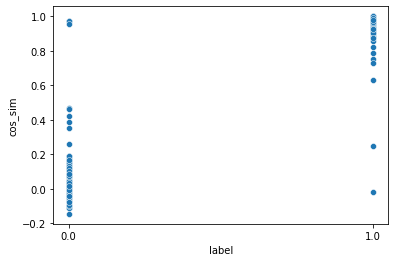

In [ ]:
from sentence_transformers import SentenceTransformer, util
import seaborn as sns
from tqdm.auto import tqdm
tqdm.pandas()

# util.cos_sim
test_df['cos_sim'] = test_df.progress_apply(lambda row: util.pytorch_cos_sim(model.encode(row['sentence1']), model.encode(row['sentence2'])).item(), axis=1)
test_df['label'] = test_df['label'].astype(str)
sns.scatterplot(data=test_df, y='cos_sim', x='label')

# Without fine tuning

  0%|          | 0/178 [00:00<?, ?it/s]

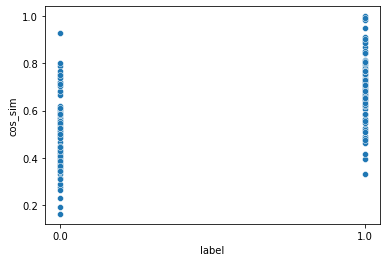

In [ ]:
from sentence_transformers import SentenceTransformer, SentencesDataset, InputExample, evaluation, losses
from torch.utils.data import DataLoader

model_noft = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

test_df['cos_sim'] = test_df.progress_apply(lambda row: util.pytorch_cos_sim(model_noft.encode(row['sentence1']), model_noft.encode(row['sentence2'])).item(), axis=1)
test_df['label'] = test_df['label'].astype(str)
sns.scatterplot(data=test_df, y='cos_sim', x='label')

# Load Fine-tuned Model

In [ ]:
! pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('/content/drive/My Drive/work/重复线索识别/models/sb')

In [ ]:
sent1 = '古桑街道石龙村李营组中心路有人倾倒垃圾来电希望尽快清理垃圾'
sent2 = '盱眙县古桑街道石龙村李营组丁能云女士反映其家靠近路边后山头有货车夜里运输噪音扰民严重'

from sentence_transformers import util
util.cos_sim(model.encode(sent1), model.encode(sent2))

tensor([[0.1784]])

In [ ]:
sent1 = '1古桑街道佛窝村刘观组内空气中弥漫猪臭味来电要求相关部门查明原因提供方案处理猪臭味问题2村内的魔剑河被倾倒大量猪屎来电要求提供方案处理河水被污染问题'
sent2 = '古桑街道佛窝村刘观组近期有人在其村组的山边建猪圈靠近居民区养猪后期气味扰民严重来电核实建猪圈是否有手续禁止在居民区附近养猪'

util.cos_sim(model.encode(sent1), model.encode(sent2))

tensor([[0.8962]])